In [2]:
#Import Spotipy packages
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from pprint import pprint
from collections import Counter
from string import punctuation
punctuation = set(punctuation)

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#Import Spotipy packages
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

In [5]:
from Spotify_keys import CLIENT_ID, CLIENT_SECRET, CLIENT_REDIRECT

In [6]:
#More Authorization flow, using variables to get access tokens to allow data extraction from Spotify API
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False

In [6]:
starting_points = ['My Chemical Romance', 'Thursday', 'Circa Survive', 'Coheed and Cambria']

In [7]:
list_of_artists = []
list_of_ids = []
list_of_uris = []
list_of_genres = []

for artist_name in starting_points:
    list_of_artists.append(artist_name)
    
    artist_search = sp.search(artist_name)
    artist_id = artist_search['tracks']['items'][0]['artists'][0]['id']
    list_of_ids.append(artist_id)
    
    
    ## Getting genre
    result = sp.search(artist_name)
    track = result['tracks']['items'][0]

    artist_info = sp.artist(track["artists"][0]["external_urls"]["spotify"])
    list_of_genres.append(artist_info["genres"])
    
    ## Getting Related Artists
    related_artist = sp.artist_related_artists(artist_id)
    RA = related_artist['artists']
    for i in range(len(RA)):
        if i not in list_of_artists:
            list_of_artists.append(RA[i]['name'])
            list_of_ids.append(RA[i]['id'])
            list_of_genres.append(RA[i]['genres'])

In [9]:
def get_RA_names_ids_genres(artists_list, ids_list, genres_list):
    artists = []
    ids = []
    genres = []
    
    for i in artists_list:
        try:
            artist_search_temp = sp.search(i)
            id_temp = artist_search_temp['tracks']['items'][0]['artists'][0]['id']
            related_artist_temp = sp.artist_related_artists(id_temp)
                        
        except spotipy.client.SpotifyException: 
            client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET) 
            sp_recover = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
                
            artist_search_temp = sp_recover.search(i)
            id_temp = artist_search_temp['tracks']['items'][0]['artists'][0]['id']
            related_artist_temp = sp_recover.artist_related_artists(id_temp)
            
        RA_temp = related_artist_temp['artists']
        
        
        for i in range(len(RA_temp)):
            if RA_temp[i]['name'] not in artists:
                artists.append(RA_temp[i]['name'])
                ids.append(RA_temp[i]['id'])
                genres.append(RA_temp[i]['genres'])
    
    artists_list.extend(artists)
    ids_list.extend(ids)
    genres_list.extend(genres)

In [10]:
get_RA_names_ids_genres(list_of_artists, list_of_ids, list_of_genres)

In [20]:
track_artist_names = [[]]
track_artist_names_ids = [[]]
track_artist_names_ids_uris = [[]]

track_ids = []
track_uris = []

for artist_id in list_of_ids:
    artist_top_tracks = sp.artist_top_tracks(artist_id)
    
    top_tracks = artist_top_tracks['tracks']

    for ind, i in enumerate(range(len(top_tracks))):
        track_artist_names.append([top_tracks[i]['artists'][0]['name'], top_tracks[i]['name']])
        
        artist_name = top_tracks[i]['artists'][0]['name']
        result = sp.search(artist_name)
        track = result['tracks']['items'][0]
        artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])
        genre = artist['genres']
        
        track_artist_names_ids_uris.append([top_tracks[i]['artists'][0]['name'],
                                            top_tracks[i]['name'],
                                            top_tracks[i]['id'],
                                            top_tracks[i]['uri'],
                                            genre])      

In [103]:
track_artist_names_ids_uris[4][4].split(',')

AttributeError: 'list' object has no attribute 'split'

In [109]:
songs_df = pd.DataFrame(track_artist_names_ids_uris, columns = ['Artist', 'Song', 'ID', 'URI', 'Genres'])
songs_df = songs_df.drop([0])

AttributeError: 'list' object has no attribute 'transpose'

In [51]:
songs_df.drop_duplicates(subset ="Song",
                     keep = 'first', inplace = True)

In [53]:
print([item for item, count in Counter(songs_df['Song']).items() if count > 1])

[]


In [54]:
list_of_ids = songs_df['ID']

In [56]:
def get_audio_features(song_ids, list_for_audio_features):
    start = 0
    end = 0
    audio_features =[]
    
    while end-1 <= len(song_ids):
        end += 100
        if end <= len(song_ids):
            try:
                songs_temp = sp.audio_features(song_ids[start:end])
            except requests.exceptions.RetryError as retry_error: 
                if retry_error.code == -1:
                    print('sleeping, 5 seconds')
                    time.sleep(5)
        else:
            try:
                songs_temp = sp.audio_features(song_ids[start:end])
            except requests.exceptions.RetryError as retry_error: 
                if retry_error.code == -1:
                    print('sleeping, 5 seconds')
                    time.sleep(5)
        audio_features.extend(songs_temp)
        start = end
    list_for_audio_features.extend(audio_features)

In [57]:
audio_features = []

get_audio_features(list_of_ids, audio_features)

In [58]:
features_df = pd.DataFrame(audio_features)
features_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.463,0.857,4,-3.063,1,0.0632,0.050600,0.000000,0.1840,0.8560,111.647,audio_features,7j31rVgGX9Q2blT92VBEA0,spotify:track:7j31rVgGX9Q2blT92VBEA0,https://api.spotify.com/v1/tracks/7j31rVgGX9Q2...,https://api.spotify.com/v1/audio-analysis/7j31...,161920,4
1,0.217,0.905,2,-4.103,1,0.0752,0.000289,0.000110,0.2220,0.2360,96.950,audio_features,5wQnmLuC1W7ATsArWACrgW,spotify:track:5wQnmLuC1W7ATsArWACrgW,https://api.spotify.com/v1/tracks/5wQnmLuC1W7A...,https://api.spotify.com/v1/audio-analysis/5wQn...,311107,4
2,0.210,0.940,9,-3.427,1,0.1230,0.006020,0.000000,0.2690,0.2550,179.722,audio_features,7lRlq939cDG4SzWOF4VAnd,spotify:track:7lRlq939cDG4SzWOF4VAnd,https://api.spotify.com/v1/tracks/7lRlq939cDG4...,https://api.spotify.com/v1/audio-analysis/7lRl...,186480,4
3,0.356,0.960,4,-3.487,1,0.1040,0.014200,0.000000,0.2090,0.0857,125.921,audio_features,5dTHtzHFPyi8TlTtzoz1J9,spotify:track:5dTHtzHFPyi8TlTtzoz1J9,https://api.spotify.com/v1/tracks/5dTHtzHFPyi8...,https://api.spotify.com/v1/audio-analysis/5dTH...,204733,4
4,0.467,0.883,2,-3.679,0,0.1060,0.000321,0.000152,0.1250,0.3090,122.252,audio_features,2d6m2F4I7wCuAKtSsdhh83,spotify:track:2d6m2F4I7wCuAKtSsdhh83,https://api.spotify.com/v1/tracks/2d6m2F4I7wCu...,https://api.spotify.com/v1/audio-analysis/2d6m...,299227,4
5,0.289,0.796,0,-4.220,1,0.0494,0.008370,0.000026,0.2020,0.3300,169.835,audio_features,4RAOI1etsgbh5NP3T5R8rN,spotify:track:4RAOI1etsgbh5NP3T5R8rN,https://api.spotify.com/v1/tracks/4RAOI1etsgbh...,https://api.spotify.com/v1/audio-analysis/4RAO...,238680,4
6,0.411,0.986,8,-2.522,0,0.0583,0.000264,0.001480,0.3710,0.6490,165.981,audio_features,5BB0Jzw60KyfSTyjJqtely,spotify:track:5BB0Jzw60KyfSTyjJqtely,https://api.spotify.com/v1/tracks/5BB0Jzw60Kyf...,https://api.spotify.com/v1/audio-analysis/5BB0...,205960,4
7,0.481,0.973,7,-1.945,1,0.0542,0.003700,0.000877,0.3250,0.3620,99.331,audio_features,0uukw2CgEIApv4IWAjXrBC,spotify:track:0uukw2CgEIApv4IWAjXrBC,https://api.spotify.com/v1/tracks/0uukw2CgEIAp...,https://api.spotify.com/v1/audio-analysis/0uuk...,195520,4
8,0.202,0.886,11,-3.805,0,0.0816,0.028600,0.000000,0.6430,0.1920,145.781,audio_features,1yKAqZoi8xWGLCf5vajroL,spotify:track:1yKAqZoi8xWGLCf5vajroL,https://api.spotify.com/v1/tracks/1yKAqZoi8xWG...,https://api.spotify.com/v1/audio-analysis/1yKA...,194253,4
9,0.236,0.799,4,-5.167,0,0.0939,0.013600,0.000000,0.0948,0.3030,208.951,audio_features,0Zh3tKIphLOvQux4dA6PFZ,spotify:track:0Zh3tKIphLOvQux4dA6PFZ,https://api.spotify.com/v1/tracks/0Zh3tKIphLOv...,https://api.spotify.com/v1/audio-analysis/0Zh3...,279027,4


In [60]:
extracted_uris = songs_df['URI'].tolist()

In [61]:
pops = []

for uri in extracted_uris:
    track = sp.track(uri)

    pop = track['popularity']
    pops.append(pop)

In [62]:
features_df['popularity'] = pops

In [64]:
songs_df = songs_df.rename(columns = {"ID":"id"})

In [65]:
main_df = pd.merge(songs_df, features_df, on = 'id')

In [67]:
main_df = main_df.drop(columns=['URI', 'uri', 'track_href', 'analysis_url', 'type'])

In [68]:
main_df.drop_duplicates(subset = ['Song'], keep = 'first')

,Artist,Song,id,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,My Chemical Romance,Teenagers,7j31rVgGX9Q2blT92VBEA0,"[emo, modern rock, pop punk, rock]",0.463,0.857,4,-3.063,1,0.0632,0.050600,0.000000,0.1840,0.8560,111.647,161920,4,82
1,My Chemical Romance,Welcome to the Black Parade,5wQnmLuC1W7ATsArWACrgW,"[emo, modern rock, pop punk, rock]",0.217,0.905,2,-4.103,1,0.0752,0.000289,0.000110,0.2220,0.2360,96.950,311107,4,78
2,My Chemical Romance,I'm Not Okay (I Promise),7lRlq939cDG4SzWOF4VAnd,"[emo, modern rock, pop punk, rock]",0.210,0.940,9,-3.427,1,0.1230,0.006020,0.000000,0.2690,0.2550,179.722,186480,4,75
3,My Chemical Romance,Helena,5dTHtzHFPyi8TlTtzoz1J9,"[emo, modern rock, pop punk, rock]",0.356,0.960,4,-3.487,1,0.1040,0.014200,0.000000,0.2090,0.0857,125.921,204733,4,74
4,My Chemical Romance,Famous Last Words,2d6m2F4I7wCuAKtSsdhh83,"[emo, modern rock, pop punk, rock]",0.467,0.883,2,-3.679,0,0.1060,0.000321,0.000152,0.1250,0.3090,122.252,299227,4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,The Safety Fire,Yellowism,34B9MoRdpqNCspK8CXGMFD,[djent],0.460,0.973,0,-5.993,1,0.0787,0.000127,0.010700,0.4240,0.2620,145.042,323387,4,18
5331,The Safety Fire,Old Souls,6uO1Nu0lXm5g9Wf019n65Q,[djent],0.511,0.953,4,-6.050,0,0.0995,0.001490,0.000190,0.2120,0.2480,150.099,445947,4,18
5332,The Safety Fire,"I Am Time, The Destroyer",4ZB2Z0VvcryCv9yC499Hsk,[djent],0.402,0.424,0,-9.200,1,0.0445,0.073900,0.001430,0.0999,0.1410,129.986,209293,3,17
5333,The Safety Fire,Glass Crush,64FsHzoR92Y44cKIK3H85C,[djent],0.259,0.954,9,-5.263,0,0.0675,0.000097,0.167000,0.1020,0.0713,101.627,308707,4,17


In [70]:
main_df.reset_index(drop = True)

,Artist,Song,id,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,My Chemical Romance,Teenagers,7j31rVgGX9Q2blT92VBEA0,"[emo, modern rock, pop punk, rock]",0.463,0.857,4,-3.063,1,0.0632,0.050600,0.000000,0.1840,0.8560,111.647,161920,4,82
1,My Chemical Romance,Welcome to the Black Parade,5wQnmLuC1W7ATsArWACrgW,"[emo, modern rock, pop punk, rock]",0.217,0.905,2,-4.103,1,0.0752,0.000289,0.000110,0.2220,0.2360,96.950,311107,4,78
2,My Chemical Romance,I'm Not Okay (I Promise),7lRlq939cDG4SzWOF4VAnd,"[emo, modern rock, pop punk, rock]",0.210,0.940,9,-3.427,1,0.1230,0.006020,0.000000,0.2690,0.2550,179.722,186480,4,75
3,My Chemical Romance,Helena,5dTHtzHFPyi8TlTtzoz1J9,"[emo, modern rock, pop punk, rock]",0.356,0.960,4,-3.487,1,0.1040,0.014200,0.000000,0.2090,0.0857,125.921,204733,4,74
4,My Chemical Romance,Famous Last Words,2d6m2F4I7wCuAKtSsdhh83,"[emo, modern rock, pop punk, rock]",0.467,0.883,2,-3.679,0,0.1060,0.000321,0.000152,0.1250,0.3090,122.252,299227,4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,The Safety Fire,Yellowism,34B9MoRdpqNCspK8CXGMFD,[djent],0.460,0.973,0,-5.993,1,0.0787,0.000127,0.010700,0.4240,0.2620,145.042,323387,4,18
5331,The Safety Fire,Old Souls,6uO1Nu0lXm5g9Wf019n65Q,[djent],0.511,0.953,4,-6.050,0,0.0995,0.001490,0.000190,0.2120,0.2480,150.099,445947,4,18
5332,The Safety Fire,"I Am Time, The Destroyer",4ZB2Z0VvcryCv9yC499Hsk,[djent],0.402,0.424,0,-9.200,1,0.0445,0.073900,0.001430,0.0999,0.1410,129.986,209293,3,17
5333,The Safety Fire,Glass Crush,64FsHzoR92Y44cKIK3H85C,[djent],0.259,0.954,9,-5.263,0,0.0675,0.000097,0.167000,0.1020,0.0713,101.627,308707,4,17


In [71]:
print([item for item, count in Counter(main_df['Song']).items() if count > 1])

[]


In [72]:
main_df.to_csv('related_artist_songs.csv')

### Lyrics Pull

In [178]:
import time
import pandas as pd
from lyricsgenius import Genius

In [179]:
access_token = 'mBLncs2Zg5K-UOsG75NC-Qg5I4YUGQKkd9Q4LqY-Z-zQCzdlF67HURibr6euEmkP'
genius = Genius(access_token)

In [180]:
df = pd.read_csv('related_artist_songs.csv')

In [76]:
artists_songs = [(x, y) for x, y in zip(df['Artist'], df['Song'])]
songs_df = pd.DataFrame(artists_songs, columns =['Artist', 'Song'])
list_of_artists = []
list_of_songs = []

lyrics_dict = {'Lyrics' : []}


for artist, song in artists_songs:
    
    while True:
        try:
            l = genius.search_song(song, artist)
    
            if l is None:
                lyrics_dict['Lyrics'].append(' ')
            else:
                lyrics = l.lyrics
                lyrics_dict['Lyrics'].append(lyrics)
                list_of_artists.append(artist)
                list_of_songs.append(song)
            break
            
        except:
            pass
        
        time.sleep(10)

Searching for "Teenagers" by My Chemical Romance...
Done.
Searching for "Welcome to the Black Parade" by My Chemical Romance...
Done.
Searching for "I'm Not Okay (I Promise)" by My Chemical Romance...
Done.
Searching for "Helena" by My Chemical Romance...
Done.
Searching for "Famous Last Words" by My Chemical Romance...
Done.
Searching for "I Don't Love You" by My Chemical Romance...
Done.
Searching for "Na Na Na (Na Na Na Na Na Na Na Na Na)" by My Chemical Romance...
Done.
Searching for "Dead!" by My Chemical Romance...
Done.
Searching for "The Ghost of You" by My Chemical Romance...
Done.
Searching for "Mama" by My Chemical Romance...
Done.
Searching for "Joyriding" by Frank Iero...
Done.
Searching for "She's the Prettiest Girl at the Party, and She Can Prove It with a Solid Right Hook" by Frank Iero...
No results found for: 'She's the Prettiest Girl at the Party, and She Can Prove It with a Solid Right Hook Frank Iero'
Searching for "Oceans" by Frank Iero...
Done.
Searching for ".we

Done.
Searching for "Brother" by Gerard Way...
Done.
Searching for "Hazy Shade of Winter (feat. Ray Toro)" by Gerard Way...
Done.
Searching for "Maya the Psychic" by Gerard Way...
Done.
Searching for "Here Comes the End (feat. Judith Hill)" by Gerard Way...
Done.
Searching for "Millions" by Gerard Way...
Done.
Searching for "Drugstore Perfume" by Gerard Way...
Done.
Searching for "Dasher (feat. Lydia Night)" by Gerard Way...
Done.
Searching for "Still into You" by Paramore...
Done.
Searching for "Misery Business" by Paramore...
Done.
Searching for "Hard Times" by Paramore...
Done.
Searching for "Ain't It Fun" by Paramore...
Done.
Searching for "The Only Exception" by Paramore...
Done.
Searching for "Interlude: I'm Not Angry Anymore" by Paramore...
Done.
Searching for "Decode" by Paramore...
Done.
Searching for "All I Wanted" by Paramore...
Done.
Searching for "That's What You Get" by Paramore...
Done.
Searching for "Ignorance" by Paramore...
Done.
Searching for "Lonely" by Palaye Royal

Done.
Searching for "Funeral" by Phoebe Bridgers...
Done.
Searching for "That Funny Feeling" by Phoebe Bridgers...
Done.
Searching for "circle the drain" by Soccer Mommy...
Done.
Searching for "Shotgun" by Soccer Mommy...
Done.
Searching for "Your Dog" by Soccer Mommy...
Done.
Searching for "yellow is the color of her eyes" by Soccer Mommy...
Done.
Searching for "bloodstream" by Soccer Mommy...
Done.
Searching for "Scorpio Rising" by Soccer Mommy...
Done.
Searching for "Wide Open Spaces" by Soccer Mommy...
Done.
Searching for "rom com 2004" by Soccer Mommy...
Done.
Searching for "rom com 2021" by Soccer Mommy...
Done.
Searching for "I'm On Fire" by Soccer Mommy...
Done.
Searching for "Dylan Thomas" by Better Oblivion Community Center...
Done.
Searching for "Didn't Know What I Was in For" by Better Oblivion Community Center...
Done.
Searching for "Sleepwalkin'" by Better Oblivion Community Center...
Done.
Searching for "Little Trouble" by Better Oblivion Community Center...
Done.
Search

Done.
Searching for "New Love Cassette" by Angel Olsen...
Done.
Searching for "Like I Used To - Acoustic Version" by Sharon Van Etten...
Done.
Searching for "All Mirrors" by Angel Olsen...
Done.
Searching for "Never Be Mine" by Angel Olsen...
Done.
Searching for "The Difference Between Medicine And Poison Is In The Dose" by Circa Survive...
Done.
Searching for "Get Out" by Circa Survive...
Done.
Searching for "Act Appalled" by Circa Survive...
Done.
Searching for "Frozen Creek" by Circa Survive...
Done.
Searching for "In Fear and Faith" by Circa Survive...
Done.
Searching for "Battle, My Love" by Circa Survive...
Done.
Searching for "Imaginary Enemy" by Circa Survive...
Done.
Searching for "Lustration" by Circa Survive...
Done.
Searching for "Living Together" by Circa Survive...
Done.
Searching for "Holding Someone's Hair Back" by Circa Survive...
Done.
Searching for "Act II: All Is Ash Or The Light Shining Through It" by The Sound Of Animals Fighting...
Done.
Searching for "Act I: Cha

Done.
Searching for "Inspire The Liars" by Dance Gavin Dance...
Done.
Searching for "Lyrics Lie" by Dance Gavin Dance...
Done.
Searching for "Son of Robot" by Dance Gavin Dance...
Done.
Searching for "Chucky vs. The Giant Tortoise" by Dance Gavin Dance...
Done.
Searching for "Betrayed By The Game" by Dance Gavin Dance...
Done.
Searching for "Care" by Dance Gavin Dance...
Done.
Searching for "January 1979" by mewithoutYou...
Done.
Searching for "In A Sweater Poorly Knit" by mewithoutYou...
Done.
Searching for "The Fox, The Crow And The Cookie" by mewithoutYou...
Done.
Searching for "Messes Of Men" by mewithoutYou...
Done.
Searching for "Julia (or, ‘Holy to the LORD’ on the Bells of Horses)" by mewithoutYou...
Done.
Searching for "Every Thought A Thought Of You" by mewithoutYou...
Done.
Searching for "Torches Together" by mewithoutYou...
Done.
Searching for "The King Beetle On A Coconut Estate" by mewithoutYou...
Done.
Searching for "Tie Me Up! Untie Me!" by mewithoutYou...
Done.
Searchi

Done.
Searching for "Ever Fallen In Love" by Thursday...
Done.
Searching for "Signals Over The Air" by Thursday...
Done.
Searching for "For The Workforce, Drowning" by Thursday...
Done.
Searching for "Cross Out The Eyes" by Thursday...
Done.
Searching for "Counting 5-4-3-2-1" by Thursday...
Done.
Searching for "Autobiography Of A Nation" by Thursday...
Done.
Searching for "Paris In Flames" by Thursday...
Done.
Searching for "The Quiet Things That No One Ever Knows" by Brand New...
Done.
Searching for "Sic Transit Gloria ... Glory Fades" by Brand New...
Done.
Searching for "Jesus Christ" by Brand New...
Done.
Searching for "The Boy Who Blocked His Own Shot" by Brand New...
Done.
Searching for "Okay I Believe You, But My Tommy Gun Don't" by Brand New...
Done.
Searching for "Seventy Times 7" by Brand New...
Done.
Searching for "Sowing Season (Yeah)" by Brand New...
Done.
Searching for "Jude Law And A Semester Abroad" by Brand New...
Done.
Searching for "Failure By Design" by Brand New...


Done.
Searching for "Marvel's Spidey and His Amazing Friends Theme (Extended)" by Patrick Stump...
No results found for: 'Marvel's Spidey and His Amazing Friends Theme (Extended) Patrick Stump'
Searching for "Super Hero on the Beat" by Patrick Stump...
Done.
Searching for "Spin, Spin, Spin" by Patrick Stump...
Done.
Searching for "Explode" by Patrick Stump...
Done.
Searching for "Super Hero" by Patrick Stump...
Done.
Searching for "Trace-E Shake" by Patrick Stump...
Done.
Searching for "Run Dry (X Heart X Fingers)" by Patrick Stump...
Done.
Searching for "Better Than Me" by The Brobecks...
Done.
Searching for "Visitation Of The Ghost" by The Brobecks...
Done.
Searching for "Love At First Sight" by The Brobecks...
Done.
Searching for "Small Cuts" by The Brobecks...
Done.
Searching for "If You Like It Or Not" by The Brobecks...
Done.
Searching for "Le Velo Pour Deux" by The Brobecks...
Done.
Searching for "Goodnight Socialite" by The Brobecks...
Done.
Searching for "The Nerve" by The Bro

Done.
Searching for "The Killing Kind" by Marianas Trench...
Done.
Searching for "Here's To The Zeros" by Marianas Trench...
Done.
Searching for "Good To You" by Marianas Trench...
Done.
Searching for "Shake Tramp" by Marianas Trench...
Done.
Searching for "Cross My Heart" by Marianas Trench...
Done.
Searching for "Hey There Delilah" by Plain White T's...
Done.
Searching for "Rhythm Of Love" by Plain White T's...
Done.
Searching for "1, 2, 3, 4" by Plain White T's...
Done.
Searching for "Our Time Now" by Plain White T's...
Done.
Searching for "Hate (I Really Don't Like You)" by Plain White T's...
Done.
Searching for "The Giving Tree" by Plain White T's...
Done.
Searching for "A Lonely September" by Plain White T's...
Done.
Searching for "Should've Gone to Bed" by Plain White T's...
Done.
Searching for "Hey There Delilah - Live Acoustic" by Plain White T's...
No results found for: 'Hey There Delilah - Live Acoustic Plain White T's'
Searching for "Let Me Take You There" by Plain White T'

Done.
Searching for "The Time Is Now" by Atreyu...
Done.
Searching for "Ex's And Oh's" by Atreyu...
Done.
Searching for "Warrior" by Atreyu...
Done.
Searching for "Becoming the Bull" by Atreyu...
Done.
Searching for "Battle Drums" by Kayzo...
Done.
Searching for "Right Side Of The Bed" by Atreyu...
Done.
Searching for "House Of Gold" by Atreyu...
Done.
Searching for "Save Us" by Atreyu...
Done.
Searching for "Untouchable" by Atreyu...
Done.
Searching for "Memory" by Sugarcult...
Done.
Searching for "Bouncing Off The Walls" by Sugarcult...
Done.
Searching for "Los Angeles" by Sugarcult...
Done.
Searching for "Stuck In America" by Sugarcult...
Done.
Searching for "Pretty Girl (The Way)" by Sugarcult...
Done.
Searching for "Do It Alone" by Sugarcult...
Done.
Searching for "Memory - Acoustic Version" by Sugarcult...
Done.
Searching for "She's the Blade" by Sugarcult...
Done.
Searching for "Dead Living" by Sugarcult...
Done.
Searching for "Hate Every Beautiful Day" by Sugarcult...
Done.
Sea

Done.
Searching for "Fat Lip" by Sum 41...
Done.
Searching for "Still Waiting" by Sum 41...
Done.
Searching for "Pieces" by Sum 41...
Done.
Searching for "The Hell Song" by Sum 41...
Done.
Searching for "With Me" by Sum 41...
Done.
Searching for "No Reason" by Sum 41...
Done.
Searching for "Underclass Hero" by Sum 41...
Done.
Searching for "Over My Head (Better Off Dead)" by Sum 41...
Done.
Searching for "Motivation" by Sum 41...
Done.
Searching for "All The Small Things" by blink-182...
Done.
Searching for "What's My Age Again?" by blink-182...
Done.
Searching for "I Miss You" by blink-182...
Done.
Searching for "First Date" by blink-182...
Done.
Searching for "Adam's Song" by blink-182...
Done.
Searching for "The Rock Show" by blink-182...
Done.
Searching for "Feeling This" by blink-182...
Done.
Searching for "Dammit" by blink-182...
Done.
Searching for "Stay Together For The Kids" by blink-182...
Done.
Searching for "Anthem Part Two" by blink-182...
Done.
Searching for "My Friends O

Done.
Searching for "Obsessed With You" by The Orion Experience...
Done.
Searching for "The Queen of White Lies" by The Orion Experience...
Done.
Searching for "All Dolled Up" by The Orion Experience...
Done.
Searching for "Like Sexy Dynamite" by The Orion Experience...
Done.
Searching for "There's No Love in February" by The Orion Experience...
Done.
Searching for "S.T.A.R. Child" by The Orion Experience...
Done.
Searching for "Vampire" by The Orion Experience...
Done.
Searching for "Night Eyes" by The Orion Experience...
Done.
Searching for "Blood & Money" by The Orion Experience...
Done.
Searching for "The Bidding" by Tally Hall...
Done.
Searching for "Hidden In the Sand" by Tally Hall...
Done.
Searching for "Turn the Lights Off" by Tally Hall...
Done.
Searching for "Ruler of Everything" by Tally Hall...
Done.
Searching for "&" by Tally Hall...
Done.
Searching for "Cannibal" by Tally Hall...
Done.
Searching for "Banana Man" by Tally Hall...
Done.
Searching for "Never Meant to Know" 

Done.
Searching for "Faded - Luke Christopher Remix" by Alan Walker...
Done.
Searching for "Bedroom Trip" by Luke Christopher...
Done.
Searching for "BROKEN" by Luke Christopher...
Done.
Searching for "Jameson" by Luke Christopher...
Done.
Searching for "SmallTown" by Luke Christopher...
Done.
Searching for "Famous" by Luke Christopher...
Done.
Searching for "Waterfalls" by Luke Christopher...
Done.
Searching for "Atlas" by Luke Christopher...
Done.
Searching for "Leave Me (feat. Marc E. Bassy)" by Skizzy Mars...
Done.
Searching for "Lucy" by Skizzy Mars...
Done.
Searching for "Girl on a Train" by Skizzy Mars...
Done.
Searching for "Calabasas" by Skizzy Mars...
Done.
Searching for "Time (feat. G-Eazy & Olivver the Kid)" by Skizzy Mars...
Done.
Searching for "Weekend Millionaires" by Skizzy Mars...
Done.
Searching for "Problems Too" by Skizzy Mars...
Done.
Searching for "STROBE LIGHTS" by 30...
Done.
Searching for "Steady 1234 (feat. Jasmine Thompson & Skizzy Mars)" by Vice...
Done.
Sea

Done.
Searching for "Arizona" by Hey Monday...
Done.
Searching for "I Don't Wanna Dance" by Hey Monday...
Done.
Searching for "Josey" by Hey Monday...
Done.
Searching for "Set Off" by Hey Monday...
Done.
Searching for "Time After Time" by Quietdrive...
Done.
Searching for "Africa" by Quietdrive...
Done.
Searching for "Forget the Lies" by Quietdrive...
Done.
Searching for "Until the End - Acoustic" by Quietdrive...
Done.
Searching for "Even When I'm Gone" by Quietdrive...
Done.
Searching for "Uprising" by Quietdrive...
Done.
Searching for "Rise From the Ashes - New Album Version" by Quietdrive...
Done.
Searching for "Until the End" by Quietdrive...
Done.
Searching for "No Sleep (feat. Droo Hastings From Drrt)" by Quietdrive...
No results found for: 'No Sleep (feat. Droo Hastings From Drrt) Quietdrive'
Searching for "On My Own" by Quietdrive...
Done.
Searching for "Lollipop" by Framing Hanley...
Done.
Searching for "Hear Me Now" by Framing Hanley...
Done.
Searching for "Puzzle Pieces" by

Done.
Searching for "Bigcitydreams" by Never Shout Never...
Done.
Searching for "i love you more than you will ever know" by Never Shout Never...
Done.
Searching for "Your Biggest Fan" by Never Shout Never...
Done.
Searching for "Happy - EP Version" by Never Shout Never...
Done.
Searching for "first dance" by Never Shout Never...
Done.
Searching for "If You Can't Hang" by Sleeping With Sirens...
Done.
Searching for "If I'm James Dean, You're Audrey Hepburn" by Sleeping With Sirens...
Done.
Searching for "Better Off Dead" by Sleeping With Sirens...
Done.
Searching for "Kick Me" by Sleeping With Sirens...
Done.
Searching for "Scene One - James Dean & Audrey Hepburn" by Sleeping With Sirens...
Done.
Searching for "Scene Two - Roger Rabbit" by Sleeping With Sirens...
Done.
Searching for "Do It Now Remember It Later" by Sleeping With Sirens...
Done.
Searching for "MESS (with Kellin Quinn of Sleeping With Sirens)" by GARZI...
No results found for: 'MESS (with Kellin Quinn of Sleeping With Si

Done.
Searching for "You Said No" by Busted...
Done.
Searching for "Falling For You" by Busted...
Done.
Searching for "Sleeping With The Light On" by Busted...
Done.
Searching for "Who's David" by Busted...
Done.
Searching for "Radio" by Busted...
Done.
Searching for "Somewhere On Fullerton" by Allister...
Done.
Searching for "Scratch" by Allister...
Done.
Searching for "Flypaper" by Allister...
Done.
Searching for "Stuck" by Allister...
Done.
Searching for "5 Years" by Allister...
Done.
Searching for "Radio Player" by Allister...
Done.
Searching for "Overrated" by Allister...
Done.
Searching for "Better Late Than Forever" by Allister...
Done.
Searching for "Racecars" by Allister...
Done.
Searching for "A Thousand Miles Away" by Allister...
Done.
Searching for "99 Red Balloons" by Goldfinger...
Done.
Searching for "Superman" by Goldfinger...
Done.
Searching for "Here In Your Bedroom" by Goldfinger...
Done.
Searching for "Spokesman" by Goldfinger...
Done.
Searching for "Wallflower" by G

Done.
Searching for "Fashionably Late" by Falling In Reverse...
Done.
Searching for "Bad Girls Club" by Falling In Reverse...
Done.
Searching for "The Drug In Me Is Reimagined" by Falling In Reverse...
Done.
Searching for "Cautious" by Emarosa...
Done.
Searching for "The Past Should Stay Dead" by Emarosa...
Done.
Searching for "A Toast to the future kids!" by Emarosa...
Done.
Searching for "Don't Cry" by Emarosa...
Done.
Searching for "Givin' Up" by Emarosa...
Done.
Searching for "Sure" by Emarosa...
Done.
Searching for "So Bad" by Emarosa...
Done.
Searching for "Cloud 9" by Emarosa...
Done.
Searching for "People Like Me, We Just Don't Play" by Emarosa...
Done.
Searching for "Wait, Stay" by Emarosa...
Done.
Searching for "If You Think This Song Is About You, It Probably Is" by Destroy Rebuild Until God Shows...
Done.
Searching for "DESTINY" by Destroy Rebuild Until God Shows...
Done.
Searching for "Satellites in Motion" by Destroy Rebuild Until God Shows...
Done.
Searching for "Graveya

Done.
Searching for "Armageddon" by Alkaline Trio...
Done.
Searching for "Warbrain" by Alkaline Trio...
Done.
Searching for "Time to Waste" by Alkaline Trio...
Done.
Searching for "We've Had Enough" by Alkaline Trio...
Done.
Searching for "Movin' Right Along" by Alkaline Trio...
Done.
Searching for "True Believers" by The Bouncing Souls...
Done.
Searching for "Lean On Sheena" by The Bouncing Souls...
Done.
Searching for "Hopeless Romantic" by The Bouncing Souls...
Done.
Searching for "Manthem" by The Bouncing Souls...
Done.
Searching for "Ole" by The Bouncing Souls...
Done.
Searching for "The Gold Song" by The Bouncing Souls...
Done.
Searching for "Kate Is Great" by The Bouncing Souls...
Done.
Searching for "Sing Along Forever" by The Bouncing Souls...
Done.
Searching for "Gone" by The Bouncing Souls...
Done.
Searching for "Kids and Heroes" by The Bouncing Souls...
Done.
Searching for "Mexican Radio" by Authority Zero...
Done.
Searching for "One More Minute" by Authority Zero...
Done.


Done.
Searching for "Hurry Home (with beabadoobee & Jay Som)" by No Rome...
Done.
Searching for "Back Of My Hand" by Bachelor...
Done.
Searching for "Baybee" by Jay Som...
Done.
Searching for "Boring Again" by Luna Li...
Done.
Searching for "Turn Into" by Jay Som...
Done.
Searching for "Stay in the Car" by Bachelor...
Done.
Searching for "Superbike" by Jay Som...
Done.
Searching for "Paul" by Big Thief...
Done.
Searching for "Simulation Swarm" by Big Thief...
Done.
Searching for "Certainty" by Big Thief...
Done.
Searching for "Velvet Ring" by Big Thief...
Done.
Searching for "Spud Infinity" by Big Thief...
Done.
Searching for "Shark Smile - Edit" by Big Thief...
Done.
Searching for "Time Escaping" by Big Thief...
Done.
Searching for "Masterpiece" by Big Thief...
Done.
Searching for "Dragon New Warm Mountain I Believe in You" by Big Thief...
Done.
Searching for "Presumably Dead Arm (617 Sessions)" by Sidney Gish...
Done.
Searching for "Sin Triangle" by Sidney Gish...
Done.
Searching for

Done.
Searching for "Darkness" by Pinegrove...
Done.
Searching for "I Love You, But I Need Another Year" by Liza Anne...
Done.
Searching for "1,000 Years" by Liza Anne...
Done.
Searching for "Panic Attack" by Liza Anne...
Done.
Searching for "Ireland" by Liza Anne...
Done.
Searching for "I'm Tired, You're Lonely" by Liza Anne...
Done.
Searching for "Bummer Days" by Liza Anne...
Done.
Searching for "I Shouldn't Ghost My Therapist" by Liza Anne...
Done.
Searching for "Thin Ice" by Liza Anne...
Done.
Searching for "I Am Not in Love Anymore" by Liza Anne...
Done.
Searching for "anything" by Adrianne Lenker...
Done.
Searching for "Indiana" by Adrianne Lenker...
Done.
Searching for "zombie girl" by Adrianne Lenker...
Done.
Searching for "not a lot, just forever" by Adrianne Lenker...
Done.
Searching for "ingydar" by Adrianne Lenker...
Done.
Searching for "two reverse" by Adrianne Lenker...
Done.
Searching for "Jonathan" by Adrianne Lenker...
Done.
Searching for "symbol" by Adrianne Lenker...

Done.
Searching for "City on the Hill - Live at Shea Stadium" by Desaparecidos...
No results found for: 'City on the Hill - Live at Shea Stadium Desaparecidos'
Searching for "City on the Hill" by Desaparecidos...
Done.
Searching for "MariKKKopa" by Desaparecidos...
Done.
Searching for "Mall Of America" by Desaparecidos...
Done.
Searching for "Please Be Mine" by Molly Burch...
Done.
Searching for "Emotion feat. Wild Nothing" by Molly Burch...
Done.
Searching for "I Adore You" by Molly Burch...
Done.
Searching for "To the Boys" by Molly Burch...
Done.
Searching for "needy" by Molly Burch...
Done.
Searching for "Heart of Gold" by Molly Burch...
Done.
Searching for "Wild" by Molly Burch...
Done.
Searching for "I Love You Still" by Molly Burch...
Done.
Searching for "Downhearted" by Molly Burch...
Done.
Searching for "Kerina" by Adrianne Lenker...
Done.
Searching for "Angels" by Adrianne Lenker...
Done.
Searching for "I Still Hear You" by Adrianne Lenker...
Done.
Searching for "Candle" by B

Done.
Searching for "haunt me (x 3)" by Teen Suicide...
Done.
Searching for "no, the moon" by Teen Suicide...
Done.
Searching for "all the lonely nights in your life" by American Pleasure Club...
Done.
Searching for "everything is going to hell" by Teen Suicide...
Done.
Searching for "the same things happening to me all the time, even in my dreams" by Teen Suicide...
Done.
Searching for "if i cleaned everything" by Teen Suicide...
Done.
Searching for "I Feel Like Dying" by Teen Suicide...
Done.
Searching for "this is heaven & id die for it" by American Pleasure Club...
Done.
Searching for "everything is fine" by Teen Suicide...
Done.
Searching for "salvia plath" by Teen Suicide...
Done.
Searching for "In the Aeroplane Over the Sea" by Neutral Milk Hotel...
Done.
Searching for "Holland, 1945" by Neutral Milk Hotel...
Done.
Searching for "King of Carrot Flowers Pt. 1" by Neutral Milk Hotel...
Done.
Searching for "Two-Headed Boy" by Neutral Milk Hotel...
Done.
Searching for "Communist Dau

Done.
Searching for "Sometimes I Wonder" by Dream, Ivory...
Done.
Searching for "as i say" by Dream, Ivory...
Done.
Searching for "don't think, just do" by Dream, Ivory...
Done.
Searching for "Better in the Dark" by Jordana...
Done.
Searching for "Jump the Turnstile" by Jordana...
Done.
Searching for "Sweet to Dream" by Jordana...
Done.
Searching for "Lo on the Hi-Way" by Jordana...
Done.
Searching for "I Guess This is Life" by Jordana...
Done.
Searching for "The Party's Not Over" by Jordana...
Done.
Searching for "Ordinary Day" by Jordana...
Done.
Searching for "Catch My Drift" by Jordana...
Done.
Searching for "Pressure Point" by Jordana...
Done.
Searching for "Blondie" by Current Joys...
Done.
Searching for "Kids" by Current Joys...
Done.
Searching for "New Flesh" by Current Joys...
Done.
Searching for "Fear" by Current Joys...
Done.
Searching for "Become the Warm Jets" by Current Joys...
Done.
Searching for "A Different Age" by Current Joys...
Done.
Searching for "Televisions" by C

Done.
Searching for "Backwards" by LSD and the Search for God...
Done.
Searching for "Starshine" by LSD and the Search for God...
Done.
Searching for "(I Don't Think That We Should) Take It Slow" by LSD and the Search for God...
Done.
Searching for "Heaven" by LSD and the Search for God...
Done.
Searching for "Elizabeth" by LSD and the Search for God...
Done.
Searching for "Outer Space (Long Way Home)" by LSD and the Search for God...
Done.
Searching for "flutter" by julie...
Done.
Searching for "kit" by julie...
Done.
Searching for "starjump" by julie...
Done.
Searching for "april's-bloom" by julie...
Done.
Searching for "lochness" by julie...
Done.
Searching for "skipping tiles" by julie...
Done.
Searching for "daisy pusher" by julie...
Done.
Searching for "she was here then, she isn't here now." by julie...
Specified song does not contain lyrics. Rejecting.
Searching for "confirmation of entry dispatch (read)" by julie...
Specified song does not contain lyrics. Rejecting.
Searching 

Done.
Searching for "Yandere" by Jazmin Bean...
Done.
Searching for "Hello Kitty" by Jazmin Bean...
Done.
Searching for "Saccharine" by Jazmin Bean...
Done.
Searching for "Puppy Pound" by Jazmin Bean...
Done.
Searching for "Princess Castle" by Jazmin Bean...
Done.
Searching for "Worldwide Torture" by Jazmin Bean...
Done.
Searching for "Monster Truck" by Jazmin Bean...
Done.
Searching for "I'm a Slave 4 U" by Jazmin Bean...
Done.
Searching for "R U Looking 4 Me Now" by Jazmin Bean...
Done.
Searching for "Birthday Bitch" by Jazmin Bean...
Done.
Searching for "Butch 4 Butch" by Rio Romeo...
Done.
Searching for "Dyltgir?" by Rio Romeo...
Done.
Searching for "Missus Piano" by Rio Romeo...
Done.
Searching for "Soft Bitch" by Rio Romeo...
Done.
Searching for "Bet" by Rio Romeo...
Done.
Searching for "Fuck It" by Rio Romeo...
Done.
Searching for "Small Towns" by Rio Romeo...
Done.
Searching for "Hetero Heaven" by Rio Romeo...
Done.
Searching for "Gay Jokes" by Rio Romeo...
Done.
Searching for 

Done.
Searching for "Hard to Believe" by Wallows...
Done.
Searching for "Uncomfortable" by Wallows...
Done.
Searching for "Would You Be So Kind" by dodie...
Done.
Searching for "Sick of Losing Soulmates" by dodie...
Done.
Searching for "When" by dodie...
Done.
Searching for "Ready Now" by dodie...
Done.
Searching for "Love To Keep Me Warm" by Laufey...
Done.
Searching for "Cool Girl" by dodie...
Done.
Searching for "Absolutely Smitten" by dodie...
Done.
Searching for "I Kissed Someone (It Wasn't You)" by dodie...
Done.
Searching for "Prom Queen" by Beach Bunny...
Done.
Searching for "Sports" by Beach Bunny...
Done.
Searching for "Good Girls (Don’t Get Used)" by Beach Bunny...
Done.
Searching for "Painkiller" by Beach Bunny...
Done.
Searching for "Cloud 9 (feat. Tegan and Sara)" by Beach Bunny...
Done.
Searching for "Fire Escape" by Beach Bunny...
Done.
Searching for "Oxygen" by Beach Bunny...
Done.
Searching for "April" by Beach Bunny...
Done.
Searching for "Heather" by Conan Gray...
D

Done.
Searching for "Work from Home (feat. Ty Dolla $ign)" by Fifth Harmony...
Done.
Searching for "Worth It (feat. Kid Ink)" by Fifth Harmony...
Done.
Searching for "That's My Girl" by Fifth Harmony...
Done.
Searching for "I'm In Love With a Monster" by Fifth Harmony...
Done.
Searching for "All In My Head (Flex) (feat. Fetty Wap)" by Fifth Harmony...
Done.
Searching for "BO$$" by Fifth Harmony...
Done.
Searching for "Sledgehammer" by Fifth Harmony...
Done.
Searching for "Miss Movin' On" by Fifth Harmony...
Done.
Searching for "Down (feat. Gucci Mane)" by Fifth Harmony...
Done.
Searching for "Sk8er Boi" by Avril Lavigne...
Done.
Searching for "Girlfriend" by Avril Lavigne...
Done.
Searching for "What the Hell" by Avril Lavigne...
Done.
Searching for "Bite Me" by Avril Lavigne...
Done.
Searching for "I'm with You" by Avril Lavigne...
Done.
Searching for "Love It When You Hate Me (feat. blackbear)" by Avril Lavigne...
Done.
Searching for "Here's to Never Growing Up" by Avril Lavigne...
D

Done.
Searching for "Lavender" by Vacations...
Done.
Searching for "Moving Out" by Vacations...
Done.
Searching for "Swing Lynn" by Harmless...
Done.
Searching for "Swing Lynn - Slowed Version" by Harmless...
Done.
Searching for "Cool Kids" by Harmless...
Done.
Searching for "Lonely Summer" by Harmless...
Done.
Searching for "Painfully Obvious" by Harmless...
Done.
Searching for "Pretty Bones" by Harmless...
Done.
Searching for "Pier Café" by Harmless...
Done.
Searching for "Mr. Baby" by Harmless...
Done.
Searching for "Nacho's" by Harmless...
Done.
Searching for "She Likes Another Boy" by Oscar Lang...
Done.
Searching for "fall into u" by Oscar Lang...
Done.
Searching for "million little reasons" by Oscar Lang...
Done.
Searching for "you." by Oscar Lang...
Done.
Searching for "Teenage Hurt" by Oscar Lang...
Done.
Searching for "French Girl" by Oscar Lang...
Done.
Searching for "Speed Dial" by Oscar Lang...
Done.
Searching for "<restart>" by Oscar Lang...
Done.
Searching for "Talk 2 U"

Done.
Searching for "Don't Get Blood on My Prada Shoes" by The Number Twelve Looks Like You...
Done.
Searching for "Last Laughter" by The Number Twelve Looks Like You...
Done.
Searching for "Like a Cat" by The Number Twelve Looks Like You...
Done.
Searching for "Ruin The Smile" by The Number Twelve Looks Like You...
Done.
Searching for "If These Bullets Could Talk" by The Number Twelve Looks Like You...
Done.
Searching for "One Armed Scissor" by At the Drive-In...
Done.
Searching for "Napoleon Solo" by At the Drive-In...
Done.
Searching for "Arcarsenal" by At the Drive-In...
Done.
Searching for "Pattern Against User" by At the Drive-In...
Done.
Searching for "Invalid Litter Dept." by At the Drive-In...
Done.
Searching for "Rascuache" by At the Drive-In...
Done.
Searching for "Starslight" by At the Drive-In...
Done.
Searching for "Sleepwalk Capsules" by At the Drive-In...
Done.
Searching for "Enfilade" by At the Drive-In...
Done.
Searching for "Proxima Centauri" by At the Drive-In...
Do

Done.
Searching for "Your Tongue Ties" by Sianvar...
Done.
Searching for "Coordinate Love" by Sianvar...
Done.
Searching for "BedRoots" by Sianvar...
Done.
Searching for "Becoming the Memory" by Royal Coda...
Done.
Searching for "Even If" by Royal Coda...
Done.
Searching for "Numbing Agent" by Royal Coda...
Done.
Searching for "Cut Me Under" by Royal Coda...
Done.
Searching for "Ruby Leaf" by Royal Coda...
Done.
Searching for "Anything to Save" by Royal Coda...
Done.
Searching for "The Innocence Of" by Royal Coda...
Done.
Searching for "All in Question" by Royal Coda...
Done.
Searching for "Don’t Stay Long" by Royal Coda...
Done.
Searching for "Blood Thinner" by Royal Coda...
Done.
Searching for "Spanish Bay" by Strawberry Girls...
Specified song does not contain lyrics. Rejecting.
Searching for "Party Nights" by Strawberry Girls...
Done.
Searching for "Mini Ripper" by Strawberry Girls...
Specified song does not contain lyrics. Rejecting.
Searching for "Thank God (feat. Nic Newsham & K

Done.
Searching for "Hall of the Sky" by Hopesfall...
Done.
Searching for "Faint Object Camera" by Hopesfall...
Done.
Searching for "Tunguska" by Hopesfall...
Done.
Searching for "H.A. Wallace Space Academy" by Hopesfall...
Done.
Searching for "Bradley Fighting Vehicle" by Hopesfall...
Done.
Searching for "C.S. Lucky-One" by Hopesfall...
Done.
Searching for "Icarus" by Hopesfall...
Done.
Searching for "The Bending" by Hopesfall...
Done.
Searching for "Indignation and the Rise of the Arbiter" by Hopesfall...
Done.
Searching for "To Bloom" by Hopesfall...
Done.
Searching for "Nerdy" by Poison The Well...
Done.
Searching for "Ghostchant" by Poison The Well...
Done.
Searching for "Apathy Is a Cold Body" by Poison The Well...
Done.
Searching for "Botchla" by Poison The Well...
Done.
Searching for "Slice Paper Wrists" by Poison The Well...
Done.
Searching for "Meeting Again for the First Time" by Poison The Well...
Done.
Searching for "12/23/93" by Poison The Well...
Done.
Searching for "A W

Done.
Searching for "Better Days" by I Am The Avalanche...
Done.
Searching for "Green Eyes" by I Am The Avalanche...
Done.
Searching for "You're No Good to Me Dead" by I Am The Avalanche...
Done.
Searching for "Dive" by I Am The Avalanche...
Done.
Searching for "Brooklyn Dodgers" by I Am The Avalanche...
Done.
Searching for "New Disaster" by I Am The Avalanche...
Done.
Searching for "I Took A Beating" by I Am The Avalanche...
Done.
Searching for "The Shape I'm In" by I Am The Avalanche...
Done.
Searching for "Tokyo" by I Am The Avalanche...
Done.
Searching for "Sunlight" by Lydia...
Done.
Searching for "Hospital" by Lydia...
Done.
Searching for "This Is Twice Now" by Lydia...
Done.
Searching for "Let It Cover Me Up" by Lydia...
Done.
Searching for "Georgia" by Lydia...
Done.
Searching for "One More Day" by Lydia...
Done.
Searching for "Stay Awake" by Lydia...
Done.
Searching for "I Woke Up Near The Sea" by Lydia...
Done.
Searching for "All I See" by Lydia...
Done.
Searching for "Now Th

Done.
Searching for "I Shot The Maid" by Greeley Estates...
Done.
Searching for "Go West Young Man" by Greeley Estates...
Done.
Searching for "Desperate Times Call for Desperate Housewives" by Greeley Estates...
Done.
Searching for "If I Could Be Frank, You're Ugly!" by Greeley Estates...
Done.
Searching for "Straitjacket" by Greeley Estates...
Done.
Searching for "Seven Hours" by Greeley Estates...
Done.
Searching for "Friends Are Friends For Never" by Greeley Estates...
Done.
Searching for "If We're Going Out, Let's Go Out In Style" by Greeley Estates...
Done.
Searching for "Two Birds, One Stone" by Drop Dead, Gorgeous...
Done.
Searching for "Dressed For Friend Requests" by Drop Dead, Gorgeous...
Done.
Searching for "Knife vs. Face: Round One" by Drop Dead, Gorgeous...
Done.
Searching for "Daniel, Where's The Boat?" by Drop Dead, Gorgeous...
Done.
Searching for "Girl, Are You On Your..." by Drop Dead, Gorgeous...
Done.
Searching for "Fashion Your Seatbelt" by Drop Dead, Gorgeous...
D

Done.
Searching for "Both Hands" by David Bazan...
Done.
Searching for "Curse Your Branches" by David Bazan...
Done.
Searching for "Trouble With Boys" by David Bazan...
Done.
Searching for "Please, Baby, Please" by David Bazan...
Done.
Searching for "Strange Negotiations" by David Bazan...
Done.
Searching for "Marigold & Patchwork" by The Appleseed Cast...
Done.
Searching for "Fight Song" by The Appleseed Cast...
Done.
Searching for "Fishing The Sky" by The Appleseed Cast...
Done.
Searching for "Innocent Violent Ordinary" by The Appleseed Cast...
No results found for: 'Innocent Violent Ordinary The Appleseed Cast'
Searching for "Time The Destroyer" by The Appleseed Cast...
Done.
Searching for "Forever Longing The Golden Sunsets" by The Appleseed Cast...
Done.
Searching for "Hanging Marionette" by The Appleseed Cast...
Done.
Searching for "Antihero" by The Appleseed Cast...
Done.
Searching for "On Reflection" by The Appleseed Cast...
Done.
Searching for "Chaotic Waves" by The Appleseed 

Done.
Searching for "Lower Still" by My Epic...
Done.
Searching for "Memoir" by My Epic...
Done.
Searching for "White Noises" by My Epic...
Done.
Searching for "beloved" by My Epic...
Done.
Searching for "Hail" by My Epic...
Done.
Searching for "Ghost Story" by My Epic...
Done.
Searching for "Bloody Angles" by My Epic...
Done.
Searching for "Endseekers" by Oh, Sleeper...
Done.
Searching for "Hush Yael" by Oh, Sleeper...
Done.
Searching for "Vices Like Vipers" by Oh, Sleeper...
Done.
Searching for "Son Of The Morning" by Oh, Sleeper...
Done.
Searching for "Children Of Fire" by Oh, Sleeper...
Done.
Searching for "The Finisher" by Oh, Sleeper...
Done.
Searching for "In The Wake Of Pigs" by Oh, Sleeper...
Done.
Searching for "Fissure" by Oh, Sleeper...
Done.
Searching for "The Summit" by Oh, Sleeper...
Done.
Searching for "It's Myself Vs. Being A Man" by Inhale Exhale...
Done.
Searching for "A Call To The Faithful" by Inhale Exhale...
Done.
Searching for "Redemption" by Inhale Exhale...
Do

Done.
Searching for "Sister Servant" by Davenport Cabinet...
Done.
Searching for "Rusty Knives" by Davenport Cabinet...
Done.
Searching for "Our Machine" by Davenport Cabinet...
Done.
Searching for "Aneris" by Davenport Cabinet...
No results found for: 'Aneris Davenport Cabinet'
Searching for "Glass Balloon" by Davenport Cabinet...
Done.
Searching for "The End Is Begun" by 3...
Done.
Searching for "Alien Angel" by 3...
Done.
Searching for "All That Remains" by 3...
Done.
Searching for "The Word Is Born of Flame" by 3...
Done.
Searching for "Serpents in Disguise" by 3...
Done.
Searching for "Bramfatura" by 3...
Specified song does not contain lyrics. Rejecting.
Searching for "My Divided Falling" by 3...
Done.
Searching for "Trust" by 3...
Specified song does not contain lyrics. Rejecting.
Searching for "Battle Cry" by 3...
Done.
Searching for "Wake Pig" by 3...
Done.
Searching for "The Man With No Audience" by Weerd Science...
Done.
Searching for "Conspiracy Theories w/ out Mel Gibson" 

Done.
Searching for "Metaphysical" by Mall Grab...
Done.
Searching for "Walls to Build - Mall Grab Remix" by Kllo...
No results found for: 'Walls to Build - Mall Grab Remix Kllo'
Searching for "Pool Party Music" by Mall Grab...
Specified song does not contain lyrics. Rejecting.
Searching for "Menace II Society" by Mall Grab...
Done.
Searching for "I've Always Liked Grime" by Mall Grab...
Done.
Searching for "Sunflower" by Mall Grab...
Done.
Searching for "Catching Feelings (Edit)" by Mall Grab...
Searching for "Catching Feelings (Edit)" by Mall Grab...
Done.
Searching for "Yes I Need My Generator" by Turnstile...
Done.
Searching for "Poison" by Klaus Veen...
Done.
Searching for "Fietspomp" by Klaus Veen...
No results found for: 'Fietspomp Klaus Veen'
Searching for "Smooth Arrangements" by Klaus Veen...
No results found for: 'Smooth Arrangements Klaus Veen'
Searching for "Let's Go Chest Day" by Klaus Veen...
Done.
Searching for "Ordinary Days V2" by Klaus Veen...
Specified song does not

Done.
Searching for "Ships In The Night" by Mat Kearney...
Done.
Searching for "Coming Home (Oregon)" by Mat Kearney...
Done.
Searching for "Memorized" by Mat Kearney...
Done.
Searching for "Hey Mama" by Mat Kearney...
Done.
Searching for "And the Birds Sing" by Tyrone Wells...
Done.
Searching for "Days I Will Remember" by Tyrone Wells...
Done.
Searching for "Time of Our Lives" by Tyrone Wells...
Done.
Searching for "Happy as the Sun" by Tyrone Wells...
Done.
Searching for "Use Somebody (Bonus Track)" by Tyrone Wells...
Done.
Searching for "Sink Or Swim" by Tyrone Wells...
Done.
Searching for "Running Around in My Dreams" by Tyrone Wells...
Done.
Searching for "Lift Me Up" by Tyrone Wells...
Done.
Searching for "Sea Breeze" by Tyrone Wells...
Done.
Searching for "So Close - From "Enchanted"/Soundtrack Version" by Jon McLaughlin...
No results found for: 'So Close - From "Enchanted"/Soundtrack Version Jon McLaughlin'
Searching for "Beautiful Disaster" by Jon McLaughlin...
Done.
Searching

Done.
Searching for "Touching Heaven" by Johnnyswim...
Done.
Searching for "First Try" by Johnnyswim...
Done.
Searching for "Bridges" by Johnnyswim...
Done.
Searching for "Best Thing Ever" by Johnnyswim...
Done.
Searching for "Don't Let It Get You Down" by Johnnyswim...
Done.
Searching for "Make You Feel My Love" by JJ Heller...
Done.
Searching for "I Believe in You" by JJ Heller...
Done.
Searching for "Hand to Hold" by JJ Heller...
Done.
Searching for "You Already Know" by JJ Heller...
Done.
Searching for "Moon River" by JJ Heller...
Done.
Searching for "Missing Peace" by JJ Heller...
Done.
Searching for "It'll Be Alright" by JJ Heller...
Done.
Searching for "Here Comes the Sun" by JJ Heller...
Done.
Searching for "Ordinary Days" by JJ Heller...
Done.
Searching for "Always Be My Baby" by Tim Halperin...
Done.
Searching for "Where The Adventure Begins" by Tim Halperin...
Done.
Searching for "Dance" by Tim Halperin...
Done.
Searching for "You Make My Dreams" by Tim Halperin...
Done.
Sea

Done.
Searching for "Embers and Envelopes" by Mae...
Done.
Searching for "Suspension" by Mae...
Done.
Searching for "Kaleidoscope" by Mae...
Done.
Searching for "The Everglow" by Mae...
Done.
Searching for "We're So Far Away" by Mae...
Done.
Searching for "Just Let Go" by Mae...
Done.
Searching for "Someone Else's Arms" by Mae...
Done.
Searching for "Summertime" by Mae...
Done.
Searching for "Anything" by Mae...
Done.
Searching for "Simple, Starving to Be Safe" by Daphne Loves Derby...
Done.
Searching for "Waking Up" by Daphne Loves Derby...
Done.
Searching for "Sun" by Daphne Loves Derby...
Done.
Searching for "Pollen And Salt" by Daphne Loves Derby...
Done.
Searching for "Hammers And Hearts" by Daphne Loves Derby...
Done.
Searching for "Cue the Sun!" by Daphne Loves Derby...
Done.
Searching for "Sundays" by Daphne Loves Derby...
Done.
Searching for "Hopeless Love" by Daphne Loves Derby...
Done.
Searching for "Midnight Highway" by Daphne Loves Derby...
Done.
Searching for "Middle Midd

Done.
Searching for "The Failsafe" by Misery Signals...
Done.
Searching for "The Year Summer Ended in June" by Misery Signals...
Done.
Searching for "A Victim, a Target" by Misery Signals...
Done.
Searching for "Worlds & Dreams" by Misery Signals...
Specified song does not contain lyrics. Rejecting.
Searching for "The Tempest" by Misery Signals...
Done.
Searching for "River King" by Misery Signals...
Done.
Searching for "Weight Of The World" by Misery Signals...
Done.
Searching for "Everything Will Rust" by Misery Signals...
Done.
Searching for "Sunlifter" by Misery Signals...
Done.
Searching for "Autotheist Movement I: Create" by The Faceless...
Done.
Searching for "Ancient Covenant" by The Faceless...
Done.
Searching for "Autotheist Movement II: Emancipate" by The Faceless...
Done.
Searching for "XenoChrist" by The Faceless...
Done.
Searching for "Autotheist Movement III: Deconsecrate" by The Faceless...
Done.
Searching for "An Autopsy" by The Faceless...
Done.
Searching for "Planeta

In [77]:
lyrics_df = pd.DataFrame(lyrics_dict)

In [78]:
m_df = pd.concat([songs_df, lyrics_df], axis = 1)

In [79]:
def clean_lyrics(df,column):

    df = df
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
    df[column] = df[column].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df[column] = df[column].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+","").str.replace("efil ym fo flah","")
    df[column] = df[column].str.strip()

    return df

In [80]:
clean_df = clean_lyrics(m_df,'Lyrics')

C:\Users\jackc\AppData\Local\Temp\ipykernel_37460\3611871839.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
C:\Users\jackc\AppData\Local\Temp\ipykernel_37460\3611871839.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
C:\Users\jackc\AppData\Local\Temp\ipykernel_37460\3611871839.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
C:\Users\jackc\AppData\Local\Temp\ipykernel_37460\3611871839.py:7: FutureWarning:

In [81]:
final_df =  pd.merge(main_df, clean_df, on = 'Song')

In [82]:
final_df = final_df.drop(columns= ['id', 'Artist_y'])

In [83]:
final_df = final_df.rename(columns = {"Artist_x":"Artist"})

In [18]:
new_genre_list = []

for genre in final_df['Genres']:
    genre_split = genre.split(',')
    genre_punc = "".join([ch for ch in genre_split[0] if ch not in punctuation])
    new_genre_list.append(genre_punc)

In [51]:
final_df['Top_Genre'] = new_genre_list

In [81]:
final_df.to_csv('songs_df.csv')

In [11]:
d = pd.read_csv('songs_df.csv')

In [14]:
len(d)

5335

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>],
       [<AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'popularity'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

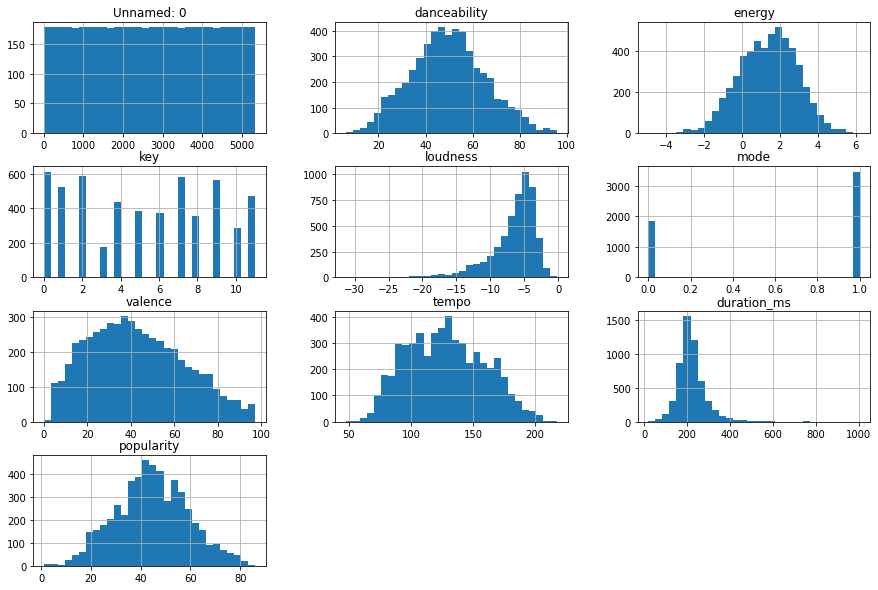

In [13]:
d.hist(bins=30, figsize=(15, 10))

## Descriptive Statistics

### Data Dictionary

#Data Dictionary

- Artist: Artist Name
- Song: Song Name
- Genres: Genres the artist falls under
- Acousticness: Numerical (0 to 100), Confidence measure from 0 to 100 of whether the track is acoustic. 1 represents high confidence the track is acoustic.
- Danceability: Numerical (0 to 100), danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0 is least danceable and 100 is most danceable.
- Duration_minutes: Integer, the duration of the track in minutes.
- Energy: Numerical (0 to 100), Energy is a measure from 0 to 100 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- Instrumentalness: Numerical (0 to 100), predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 100, the greater likelihood the track contains no vocal content. Values above 50 are intended to represent instrumental tracks, but confidence is higher as the value approaches 100.
- Key: Categorical, the estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C#/Db, 2 = D, and so on. If no key was detected, the value is -1.
- Loudness: Numerical (Float) (-60 to 0), Overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- Mode: Numerical (Dummy) (0 = Minor, 1 = Major), mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- Tempo: Numerical (Float) (typically 50 to 150), Overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- Valence: Numerical  (0 to 1), Measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- Popularity: According to Spotify, “popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.”
- Lyrics: The lyrics to the song
- Amount of Words: The total amount of words in a song
- Amount of unique words: The amount of unique words in the lyrics of a song
- Average word length: Average length of each word
- Lexical Diversity - Measurement of how many different lexical words (words that convey meaning) are present in a song
- Top 10 words: The ten words that appear the most in a song

Source: https://rpubs.com/PeterDola/SpotifyTracks

https://towardsdatascience.com/predicting-popularity-on-spotify-when-data-needs-culture-more-than-culture-needs-data-2ed3661f75f1#:~:text=According%20to%20Spotify%2C%20%E2%80%9Cpopularity%20is,a%20lot%20in%20the%20past.%E2%80%9D